### 《人工智能》课程设计二
#### 实验思路：（该设计是在13周前完成的，当时并未告知只能使用Mindsp框架，相关情况老师已经知晓，请见谅）

1.使用tensorflow中的keras作为训练框架

2.基于GRU模型进行训练

3.运用了注意力机制，体验了中译英模型的全过程

### 实验环境

tensorflow==2.12, tensorflow-text==2.12
### 实验步骤（中文翻译英文）

In [ ]:
import numpy as np

import typing
from typing import Any, Tuple

import einops
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

import tensorflow as tf
import tensorflow_text as tf_text

import jieba

In [3]:
import pathlib

zh_train_path = pathlib.Path('data/train.zh')
en_train_path = pathlib.Path('data/train.en')
zh_val_path = pathlib.Path('data/val.zh')
en_val_path = pathlib.Path('data/val.en')

### 数据预处理

1.为每个句子添加开始和结束标记。

2.通过删除特殊字符来清理句子。

3.创建单词索引和反向单词索引（从单词→id 和 id→单词映射的词典）。

4.将每个句子填充至最大长度。

### 中文的特殊处理

对中文句子，使用jieba库进行分词

In [ ]:
def load_zh_data(path):
    lines = path.read_text(encoding='utf-8').strip().split('\n')

    context = np.array([' '.join(jieba.cut(line)) for line in lines])

    return context

def load_en_data(path):
    lines = path.read_text(encoding='utf-8').strip().split('\n')

    context = np.array([line for line in lines])

    return context

zh_train_raw = load_zh_data(zh_train_path)
en_train_raw = load_en_data(en_train_path)
zh_val_raw = load_zh_data(zh_val_path)
en_val_raw = load_en_data(en_val_path)

In [ ]:
print(zh_train_raw[-1])
print(en_train_raw[-1])
print(len(zh_train_raw), len(en_train_raw), len(zh_val_raw), len(en_val_raw))

随着 对 日本 资本主义 神奇 力量 信心 的 逐渐 减退 ， 1991 年 以后 日本 主要 城市 的 地价 一直 处在 稳步 的 回落 当中 。
Urban land prices in major Japanese cities have steadily dropped over much of the period since 1991, as the enormous faith in the miraculous powers of Japanese capitalism gradually faded.
214860 214860 12639 12639


### 验证集、训练集合并

由于要解决验证集、训练集的词汇表要统一的问题，对验证集、训练集进行合并

In [ ]:
context_raw = np.concatenate((zh_train_raw, zh_val_raw))
target_raw = np.concatenate((en_train_raw, en_val_raw))

In [ ]:
print(f"context_raw size: {len(context_raw)}")
print(f"target_raw size: {len(target_raw)}")

context_raw size: 227499
target_raw size: 227499


### 创建 tf.data 数据集

通过这些字符串数组，创建一个tf.data.Dataset字符串数组，以有效地对它们进行打乱和批处理：

前95%为训练集，后5%为验证集。

In [ ]:
BUFFER_SIZE = len(context_raw)
BATCH_SIZE = 64
split_idx = int(0.95 * BUFFER_SIZE)

train_raw = (
    tf.data.Dataset
    .from_tensor_slices((context_raw[:split_idx], target_raw[:split_idx]))
    .shuffle(BUFFER_SIZE)
    .batch(BATCH_SIZE))
val_raw = (
    tf.data.Dataset
    .from_tensor_slices((context_raw[split_idx:], target_raw[split_idx:]))
    .shuffle(BUFFER_SIZE)
    .batch(BATCH_SIZE))

In [ ]:
for example_context_strings, example_target_strings in train_raw.take(1):
    print([s.numpy().decode() for s in example_context_strings[:5]])
    print()
    print(example_target_strings[:5])
    break

['俄国 简直 是 用 大 把 的 钞票 买 回 了 国际 体系 中 引人注目 的 地位 ， 石油 和 天然气 代替 核武器 ， 为 俄国 重新 赢回 了 权力 和 影响 ， 贪婪 也 最终 代替 了 恐惧 。', '· 用 一个 互助 稳定 基金 支持 下 的 增长 战略 去 代替 紧缩 ;', '叙利亚 危机 爆发 时 ， 没 人 预测 到 会 如此 严重 、 漫长 和 复杂 。', '如此 大规模 不但 对 全球 经济 日益 重要 ， 也 日益 有利于 制衡 中国 在 亚洲 的 影响力 以及 管理 气候变化 、 公共卫生 和 网络安全 等 全球性 问题 。', '美国 每年 的 预算赤字 达到 GNP 的 5% ， 而且 差额 中有 很大 一部分 来自 亚洲各国 的 中央银行 。   这些 央行 目前 已经 持有 2 万亿美元 的 美国 国债 。']

tf.Tensor(
[b'Russia is literally buying its way back into the international system as a preeminent actor, one that is regaining power and clout by replacing nuclear weapons with oil and gas and substituting greed for fear.'
 b'\xc2\xb7 replacing austerity with a growth strategy, supported by a solidarity fund for stabilization;'
 b'When the crisis in Syria erupted, nobody predicted how serious, protracted, and complex it would turn out to be.'
 b'Its sheer scale will be increasingly important not only to the global economy, but also to balancing China\xe2\x80\x99s influence in Asia and managing global issue

为了使导出的模型有用，它应该接受tf.string输入并返回tf.string输出：所有文本处理都在模型内部进行。主要使用layers.TextVectorization层。

#### 标准化

该模型处理的是词汇量有限的多语言文本。因此，标准化输入文本非常重要。

第一步是 Unicode 规范化，以拆分重音字符并用 ASCII 等效字符替换兼容字符。

该tensorflow_text包包含一个unicode规范化操作：

In [ ]:
def tf_lower_and_split_punct(text):
  # Split accented characters.
  text = tf_text.normalize_utf8(text, 'NFKD')
  text = tf.strings.lower(text)
  # Keep space, a to z, and select punctuation.
  text = tf.strings.regex_replace(text, '[^ 一-龥0-9a-z.?!,¿]', '')
  # Add spaces around punctuation.
  text = tf.strings.regex_replace(text, '[.?!,¿]', r' \0 ')
  # Strip whitespace.
  text = tf.strings.strip(text)

  text = tf.strings.join(['[START]', text, '[END]'], separator=' ')
  return text

In [ ]:
example_text = tf.constant('我 是 你 爸爸')

print(example_text.numpy().decode())
print(tf_lower_and_split_punct(example_text).numpy().decode())

我 是 你 爸爸
[START] 我 是 你 爸爸 [END]


#### 文本矢量化

这个标准化函数将被包裹在一个tf.keras.layers.TextVectorization层中，该层将处理词汇提取和输入文本到标记序列的转换。

In [ ]:
max_vocab_size = 5000

context_text_processor = tf.keras.layers.TextVectorization(
    standardize=tf_lower_and_split_punct,
    max_tokens=max_vocab_size,
    ragged=True)

该TextVectorization层和许多其他Keras 预处理层都有一个adapt方法。此方法读取一个时期的训练数据，其工作原理与 非常相似Model.fit。此adapt方法根据数据初始化该层。在这里它确定词汇表：

In [ ]:
context_text_processor.adapt(train_raw.map(lambda context, target: context))

# Here are the first 10 words from the vocabulary:
print(context_text_processor.get_vocabulary()[:10])

['', '[UNK]', '的', ',', '[START]', '[END]', '在', '和', '是', '了']


这是中文TextVectorization层，现在构建.adapt()英语层：

In [ ]:
target_text_processor = tf.keras.layers.TextVectorization(
    standardize=tf_lower_and_split_punct,
    max_tokens=max_vocab_size,
    ragged=True)

target_text_processor.adapt(train_raw.map(lambda context, target: target))
target_text_processor.get_vocabulary()[:10]

['', '[UNK]', 'the', ',', '[START]', '[END]', '.', 'of', 'to', 'and']

现在这些层可以将一批字符串转换为一批令牌 ID

In [ ]:
example_tokens = context_text_processor(example_context_strings)
print(example_tokens[:3, :])

<tf.RaggedTensor [[4, 814, 4213, 8, 255, 140, 133, 2, 1, 3125, 3824, 9, 96, 367, 19, 3544, 2,
  441, 3, 408, 7, 929, 3409, 816, 3, 34, 814, 359, 1, 9, 342, 7, 97, 3,
  3858, 10, 240, 3409, 9, 1368, 5]                                          ,
 [4, 255, 21, 1, 198, 624, 85, 86, 2, 58, 288, 343, 3409, 700, 5],
 [4, 309, 106, 580, 93, 3, 1092, 41, 654, 45, 29, 176, 263, 2534, 7, 781, 5]]>


该get_vocabulary方法可用于将 token ID 转换回文本：

In [ ]:
context_vocab = np.array(context_text_processor.get_vocabulary())
for e in example_tokens[:3, :]:
    tokens = context_vocab[e.numpy()]
    print(' '.join(tokens))


[START] 俄国 简直 是 用 大 把 的 [UNK] 买 回 了 国际 体系 中 引人注目 的 地位 , 石油 和 天然气 代替 核武器 , 为 俄国 重新 [UNK] 了 权力 和 影响 , 贪婪 也 最终 代替 了 恐惧 [END]
[START] 用 一个 [UNK] 稳定 基金 支持 下 的 增长 战略 去 代替 紧缩 [END]
[START] 叙利亚 危机 爆发 时 , 没 人 预测 到 会 如此 严重 漫长 和 复杂 [END]


返回的 token ID 以零填充。这可以很容易地变成一个掩码：

Text(0.5, 1.0, 'Mask')

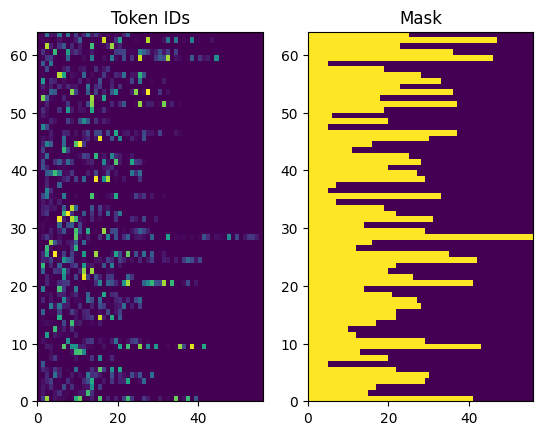

In [ ]:
plt.subplot(1, 2, 1)
plt.pcolormesh(example_tokens.to_tensor())
plt.title('Token IDs')

plt.subplot(1, 2, 2)
plt.pcolormesh(example_tokens.to_tensor() != 0)
plt.title('Mask')

### 处理数据集

下面的函数将字符串的process_text转换Datasets为以 0 填充的标记 ID 张量。它还将一(context, target)对转换为一对，((context, target_in), target_out)以便使用 进行训练keras.Model.fit。Keras 期望(inputs, labels)成对，输入是(context, target_in)，标签是。和target_out之间的区别在于它们相对于彼此移动了一步，因此在每个位置，标签都是下一个标记。target_intarget_out

In [ ]:
def process_text(context, target):
    context = context_text_processor(context).to_tensor()
    target = target_text_processor(target)
    targ_in = target[:,:-1].to_tensor()
    targ_out = target[:,1:].to_tensor()
    return (context, targ_in), targ_out


train_ds = train_raw.map(process_text, tf.data.AUTOTUNE)
val_ds = val_raw.map(process_text, tf.data.AUTOTUNE)

以下是第一批中每个的第一个序列：

In [ ]:
for (ex_context_tok, ex_tar_in), ex_tar_out in train_ds.take(1):
    print(ex_context_tok[0, :10].numpy())
    print()
    print(ex_tar_in[0, :10].numpy())
    print(ex_tar_out[0, :10].numpy())

[   4 2325   32    8    3    1    1 2837 1399    2]

[   4    2  108  346   13  232    1    1 2082 1857]
[   2  108  346   13  232    1    1 2082 1857    8]


### 编码器/解码器

在两个图中，编码器位于左侧，解码器位于右侧。在每个时间步骤中，解码器的输出与编码器的输出相结合，以预测下一个单词。

原始的 [左] 包含一些额外的连接，这些连接被故意从本教程的模型 [右] 中省略，因为它们通常是不必要的，而且很难实现。这些缺失的连接是：

1.将状态从编码器的 RNN 馈送到解码器的 RNN

2.将注意力输出反馈给 RNN 的输入。

![Attention Mechanism](attention_mechanism.jpg)

在进入之前定义模型的常量：



In [ ]:
UNITS = 512

由于使用了大量低级 API，因此很容易出现形状错误。本类用于检查形状。

In [ ]:
class ShapeChecker():
    def __init__(self):
        # Keep a cache of every axis-name seen
        self.shapes = {}

    def __call__(self, tensor, names, broadcast=False):
        if not tf.executing_eagerly():
            return

        parsed = einops.parse_shape(tensor, names)

        for name, new_dim in parsed.items():
            old_dim = self.shapes.get(name, None)

            if (broadcast and new_dim == 1):
                continue

            if old_dim is None:
                # If the axis name is new, add its length to the cache.
                self.shapes[name] = new_dim
                continue

            if new_dim != old_dim:
                raise ValueError(f"Shape mismatch for dimension: '{name}'\n"
                                 f"    found: {new_dim}\n"
                                 f"    expected: {old_dim}\n")

### 编码器

编码器的目标是将上下文序列处理成一系列向量，这些向量对解码器很有用，因为它会尝试预测每个时间步的下一个输出。由于上下文序列是恒定的，因此对信息在编码器中的流动方式没有限制，因此可以使用双向 RNN 进行处理：

![RNN Bidirectional](RNN-bidirectional.png)

编码器：

1.获取令牌 ID 列表（来自context_text_processor）。

2.查找每个标记的嵌入向量（使用layers.Embedding）。

3.将嵌入处理成一个新的序列（使用双向layers.GRU）。

4.返回已处理好的序列。这将被传递给注意力头。

In [ ]:
class Encoder(tf.keras.layers.Layer):
    def __init__(self, text_processor, units):
        super(Encoder, self).__init__()
        self.text_processor = text_processor
        self.vocab_size = text_processor.vocabulary_size()
        self.units = units

        # The embedding layer converts tokens to vectors
        self.embedding = tf.keras.layers.Embedding(self.vocab_size, units,
                                                   mask_zero=True)

        # The RNN layer processes those vectors sequentially.
        self.rnn = tf.keras.layers.Bidirectional(
            merge_mode='sum',
            layer=tf.keras.layers.GRU(units,
                                      # Return the sequence and state
                                      return_sequences=True,
                                      recurrent_initializer='glorot_uniform'))

    def call(self, x):
        shape_checker = ShapeChecker()
        shape_checker(x, 'batch s')

        # 2. The embedding layer looks up the embedding vector for each token.
        x = self.embedding(x)
        shape_checker(x, 'batch s units')

        # 3. The GRU processes the sequence of embeddings.
        x = self.rnn(x)
        shape_checker(x, 'batch s units')

        # 4. Returns the new sequence of embeddings.
        return x

    def convert_input(self, texts):
        texts = tf.convert_to_tensor(texts)
        if len(texts.shape) == 0:
            texts = tf.convert_to_tensor(texts)[tf.newaxis]
        context = self.text_processor(texts).to_tensor()
        context = self(context)
        return context

尝试一下：

In [ ]:
# Encode the input sequence.
encoder = Encoder(context_text_processor, UNITS)
ex_context = encoder(ex_context_tok)

print(f'Context tokens, shape (batch, s): {ex_context_tok.shape}')
print(f'Encoder output, shape (batch, s, units): {ex_context.shape}')

Context tokens, shape (batch, s): (64, 56)
Encoder output, shape (batch, s, units): (64, 56, 512)


### 注意力层

注意层让解码器可以访问编码器提取的信息。它根据整个上下文序列计算出一个向量，并将其添加到解码器的输出中。

从整个序列计算单个向量的最简单方法是取整个序列的平均值（layers.GlobalAveragePooling1D）。注意层类似，但计算整个上下文序列的加权平均值。其中权重是根据上下文和“查询”向量的组合计算出来的。

![Cross Attention New Full](CrossAttention-new-full.png)

In [ ]:
class CrossAttention(tf.keras.layers.Layer):
    def __init__(self, units, **kwargs):
        super().__init__()
        self.mha = tf.keras.layers.MultiHeadAttention(key_dim=units, num_heads=1, **kwargs)
        self.layernorm = tf.keras.layers.LayerNormalization()
        self.add = tf.keras.layers.Add()

    def call(self, x, context):
        shape_checker = ShapeChecker()

        shape_checker(x, 'batch t units')
        shape_checker(context, 'batch s units')

        attn_output, attn_scores = self.mha(
            query=x,
            value=context,
            return_attention_scores=True)

        shape_checker(x, 'batch t units')
        shape_checker(attn_scores, 'batch heads t s')

        # Cache the attention scores for plotting later.
        attn_scores = tf.reduce_mean(attn_scores, axis=1)
        shape_checker(attn_scores, 'batch t s')
        self.last_attention_weights = attn_scores

        x = self.add([x, attn_output])
        x = self.layernorm(x)

        return x

In [ ]:
attention_layer = CrossAttention(UNITS)

# Attend to the encoded tokens
embed = tf.keras.layers.Embedding(target_text_processor.vocabulary_size(),
                                  output_dim=UNITS, mask_zero=True)
ex_tar_embed = embed(ex_tar_in)

result = attention_layer(ex_tar_embed, ex_context)

print(f'Context sequence, shape (batch, s, units): {ex_context.shape}')
print(f'Target sequence, shape (batch, t, units): {ex_tar_embed.shape}')
print(f'Attention result, shape (batch, t, units): {result.shape}')
print(f'Attention weights, shape (batch, t, s):    {attention_layer.last_attention_weights.shape}')

Context sequence, shape (batch, s, units): (64, 56, 512)
Target sequence, shape (batch, t, units): (64, 55, 512)
Attention result, shape (batch, t, units): (64, 55, 512)
Attention weights, shape (batch, t, s):    (64, 55, 56)


1在目标序列中的每个位置，注意力权重将会在上下文序列上相加。

In [ ]:
attention_layer.last_attention_weights[0].numpy().sum(axis=-1)

array([0.99999994, 1.0000001 , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       0.99999994, 1.0000001 , 1.        , 1.        , 1.        ,
       1.0000001 , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ],
      dtype=float32)

以下是上下文序列的注意力权重t=0：

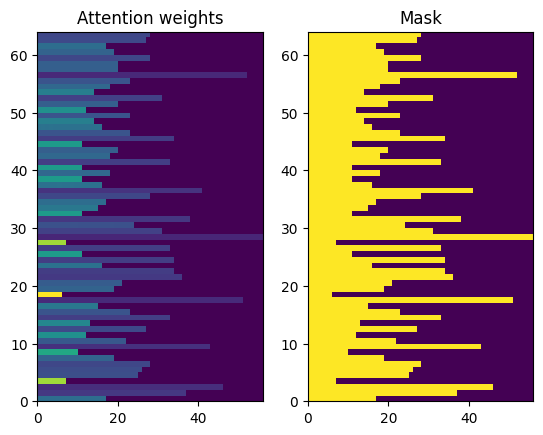

In [ ]:
attention_weights = attention_layer.last_attention_weights
mask=(ex_context_tok != 0).numpy()

plt.subplot(1, 2, 1)
plt.pcolormesh(mask*attention_weights[:, 0, :])
plt.title('Attention weights')

plt.subplot(1, 2, 2)
plt.pcolormesh(mask)
plt.title('Mask');

由于初始化时随机性较小，注意力权重最初都接近于1/(sequence_length)。随着训练的进行，模型将学会让这些权重变得不那么统一。


### 解码器
解码器的工作是针对目标序列中每个位置的下一个标记生成预测。

1.它查找目标序列中每个标记的嵌入。

2.它使用 RNN 来处理目标序列，并跟踪迄今为止生成的内容。

3.在关注编码器的输出时，它使用 RNN 输出作为注意层的“查询”。

4.它会在输出的每个位置预测下一个标记。

在训练时，模型会预测每个位置的下一个单词。因此，信息在模型中只朝一个方向流动非常重要。解码器使用单向（而非双向）RNN 来处理目标序列。

当使用该模型进行推理时，它每次会生成一个单词，然后这些单词会反馈到模型中。

![RNN](RNN.png)

这是Decoder类的初始化程序。初始化程序创建了所有必要的层。

In [ ]:
class Decoder(tf.keras.layers.Layer):
    @classmethod
    def add_method(cls, fun):
        setattr(cls, fun.__name__, fun)
        return fun

    def __init__(self, text_processor, units):
        super(Decoder, self).__init__()
        self.text_processor = text_processor
        self.vocab_size = text_processor.vocabulary_size()
        self.word_to_id = tf.keras.layers.StringLookup(
            vocabulary=text_processor.get_vocabulary(),
            mask_token='', oov_token='[UNK]')
        self.id_to_word = tf.keras.layers.StringLookup(
            vocabulary=text_processor.get_vocabulary(),
            mask_token='', oov_token='[UNK]',
            invert=True)
        self.start_token = self.word_to_id('[START]')
        self.end_token = self.word_to_id('[END]')

        self.units = units


        # 1. The embedding layer converts token IDs to vectors
        self.embedding = tf.keras.layers.Embedding(self.vocab_size,
                                                   units, mask_zero=True)

        # 2. The RNN keeps track of what's been generated so far.
        self.rnn = tf.keras.layers.GRU(units,
                                       return_sequences=True,
                                       return_state=True,
                                       recurrent_initializer='glorot_uniform')

        # 3. The RNN output will be the query for the attention layer.
        self.attention = CrossAttention(units)

        # 4. This fully connected layer produces the logits for each
        # output token.
        self.output_layer = tf.keras.layers.Dense(self.vocab_size)

#### 训练
接下来，该call方法接受 3 个参数：

inputs-context, x一对，其中：

context- 是来自编码器输出的上下文。

x- 是目标序列输入。

state- 可选，state解码器的上一次输出（解码器 RNN 的内部状态）。传递上一次运行的状态以继续从上次中断的地方生成文本。

return_state- [默认值：False] - 将其设置为True返回 RNN 状态。

In [ ]:
@Decoder.add_method
def call(self,
         context, x,
         state=None,
         return_state=False):
    shape_checker = ShapeChecker()
    shape_checker(x, 'batch t')
    shape_checker(context, 'batch s units')

    # 1. Lookup the embeddings
    x = self.embedding(x)
    shape_checker(x, 'batch t units')

    # 2. Process the target sequence.
    x, state = self.rnn(x, initial_state=state)
    shape_checker(x, 'batch t units')

    # 3. Use the RNN output as the query for the attention over the context.
    x = self.attention(x, context)
    self.last_attention_weights = self.attention.last_attention_weights
    shape_checker(x, 'batch t units')
    shape_checker(self.last_attention_weights, 'batch t s')

    # Step 4. Generate logit predictions for the next token.
    logits = self.output_layer(x)
    shape_checker(logits, 'batch t target_vocab_size')

    if return_state:
        return logits, state
    else:
        return logits

这对于训练来说已经足够了。创建一个解码器实例来测试：

In [ ]:
decoder = Decoder(target_text_processor, UNITS)

在训练中你将像这样使用解码器：

给定上下文和目标标记，它会针对每个目标标记预测下一个目标标记。

In [ ]:
logits = decoder(ex_context, ex_tar_in)

print(f'encoder output shape: (batch, s, units) {ex_context.shape}')
print(f'input target tokens shape: (batch, t) {ex_tar_in.shape}')
print(f'logits shape shape: (batch, target_vocabulary_size) {logits.shape}')

encoder output shape: (batch, s, units) (64, 56, 512)
input target tokens shape: (batch, t) (64, 55)
logits shape shape: (batch, target_vocabulary_size) (64, 55, 5000)


推理

要使用它进行推理，还需要加入其他的方法：

In [ ]:
@Decoder.add_method
def get_initial_state(self, context):
    batch_size = tf.shape(context)[0]
    start_tokens = tf.fill([batch_size, 1], self.start_token)
    done = tf.zeros([batch_size, 1], dtype=tf.bool)
    embedded = self.embedding(start_tokens)
    return start_tokens, done, self.rnn.get_initial_state(embedded)[0]

In [ ]:
@Decoder.add_method
def tokens_to_text(self, tokens):
    words = self.id_to_word(tokens)
    result = tf.strings.reduce_join(words, axis=-1, separator=' ')
    result = tf.strings.regex_replace(result, '^ *\[START\] *', '')
    result = tf.strings.regex_replace(result, ' *\[END\] *$', '')
    return result

In [ ]:
@Decoder.add_method
def get_next_token(self, context, next_token, done, state, temperature = 0.0):
    logits, state = self(
        context, next_token,
        state = state,
        return_state=True)

    if temperature == 0.0:
        next_token = tf.argmax(logits, axis=-1)
    else:
        logits = logits[:, -1, :]/temperature
        next_token = tf.random.categorical(logits, num_samples=1)

    # If a sequence produces an `end_token`, set it `done`
    done = done | (next_token == self.end_token)
    # Once a sequence is done it only produces 0-padding.
    next_token = tf.where(done, tf.constant(0, dtype=tf.int64), next_token)

    return next_token, done, state

利用这些额外的函数，可以编写一个生成循环：

In [ ]:
# Setup the loop variables.
next_token, done, state = decoder.get_initial_state(ex_context)
tokens = []

for n in range(10):
    # Run one step.
    next_token, done, state = decoder.get_next_token(
        ex_context, next_token, done, state, temperature=1.0)
    # Add the token to the output.
    tokens.append(next_token)

# Stack all the tokens together.
tokens = tf.concat(tokens, axis=-1) # (batch, t)

# Convert the tokens back to a a string
result = decoder.tokens_to_text(tokens)
result[:3].numpy()

array([b'nineteenthcentury understood unlikely longstanding friends farm arms campaign greenhouse algeria',
       b'daunting half interested map barack told debates saved before borrowers',
       b'90 ironically exclusively driver troika immense poll identity abenomics intervene'],
      dtype=object)

由于该模型未经训练，它几乎均匀地随机输出词汇表中的项目。

### 模型

设计完所有的模型组件后，将它们组合起来以构建用于训练的模型：

In [ ]:
class Translator(tf.keras.Model):
    @classmethod
    def add_method(cls, fun):
        setattr(cls, fun.__name__, fun)
        return fun

    def __init__(self, units,
                 context_text_processor,
                 target_text_processor):
        super().__init__()
        # Build the encoder and decoder
        encoder = Encoder(context_text_processor, units)
        decoder = Decoder(target_text_processor, units)

        self.encoder = encoder
        self.decoder = decoder

    def call(self, inputs):
        context, x = inputs
        context = self.encoder(context)
        logits = self.decoder(context, x)

        #TODO(b/250038731): remove this
        try:
            # Delete the keras mask, so keras doesn't scale the loss+accuracy.
            del logits._keras_mask
        except AttributeError:
            pass

        return logits

在训练期间，模型将按如下方式使用：

In [ ]:
model = Translator(UNITS, context_text_processor, target_text_processor)

logits = model((ex_context_tok, ex_tar_in))

print(f'Context tokens, shape: (batch, s, units) {ex_context_tok.shape}')
print(f'Target tokens, shape: (batch, t) {ex_tar_in.shape}')
print(f'logits, shape: (batch, t, target_vocabulary_size) {logits.shape}')

Context tokens, shape: (batch, s, units) (64, 56)
Target tokens, shape: (batch, t) (64, 55)
logits, shape: (batch, t, target_vocabulary_size) (64, 55, 5000)


### 训练

对于训练，您需要自己实现计算损失和准确率

In [ ]:
def masked_loss(y_true, y_pred):
    # Calculate the loss for each item in the batch.
    loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(
        from_logits=True, reduction='none')
    loss = loss_fn(y_true, y_pred)

    # Mask off the losses on padding.
    mask = tf.cast(y_true != 0, loss.dtype)
    loss *= mask

    # Return the total.
    return tf.reduce_sum(loss)/tf.reduce_sum(mask)

In [ ]:
def masked_acc(y_true, y_pred):
    # Calculate the loss for each item in the batch.
    y_pred = tf.argmax(y_pred, axis=-1)
    y_pred = tf.cast(y_pred, y_true.dtype)

    match = tf.cast(y_true == y_pred, tf.float32)
    mask = tf.cast(y_true != 0, tf.float32)

    return tf.reduce_sum(match)/tf.reduce_sum(mask)

配置模型进行训练：

In [ ]:
model.compile(optimizer='adam',
              loss=masked_loss,
              metrics=[masked_acc, masked_loss])

该模型是随机初始化的，应该给出大致均匀的输出概率。因此很容易预测指标的初始值应该是什么：

In [ ]:
vocab_size = 1.0 * target_text_processor.vocabulary_size()

{"expected_loss": tf.math.log(vocab_size).numpy(),
 "expected_acc": 1/vocab_size}

{'expected_loss': 8.517193, 'expected_acc': 0.0002}

这应该与运行几个评估步骤所返回的值大致匹配：

In [ ]:
model.evaluate(val_ds, steps=20, return_dict=True)

20/20 [==============================] - 11s 247ms/step - loss: 8.5454 - masked_acc: 3.2977e-04 - masked_loss: 8.5454


{'loss': 8.545373916625977,
 'masked_acc': 0.00032977250521071255,
 'masked_loss': 8.545373916625977}

如果验证损失在连续 3 个 epoch 中没有改善，训练将提前停止，以防止过拟合。

In [ ]:
history = model.fit(
    train_ds.repeat(),
    epochs=100,
    steps_per_epoch = 100,
    validation_data=val_ds,
    validation_steps = 20,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(patience=3)])

Epoch 1/100
100/100 [==============================] - 76s 648ms/step - loss: 5.6431 - masked_acc: 0.1698 - masked_loss: 5.6431 - val_loss: 5.0158 - val_masked_acc: 0.2273 - val_masked_loss: 5.0158
Epoch 2/100
100/100 [==============================] - 66s 658ms/step - loss: 4.8331 - masked_acc: 0.2397 - masked_loss: 4.8331 - val_loss: 4.6712 - val_masked_acc: 0.2492 - val_masked_loss: 4.6712
Epoch 3/100
100/100 [==============================] - 66s 658ms/step - loss: 4.5410 - masked_acc: 0.2606 - masked_loss: 4.5410 - val_loss: 4.4192 - val_masked_acc: 0.2680 - val_masked_loss: 4.4192
Epoch 4/100
100/100 [==============================] - 68s 683ms/step - loss: 4.2687 - masked_acc: 0.2823 - masked_loss: 4.2687 - val_loss: 4.1559 - val_masked_acc: 0.2928 - val_masked_loss: 4.1559
Epoch 5/100
100/100 [==============================] - 66s 659ms/step - loss: 4.0641 - masked_acc: 0.2997 - masked_loss: 4.0641 - val_loss: 3.9721 - val_masked_acc: 0.3096 - val_masked_loss: 3.9721
Epoch 6/10

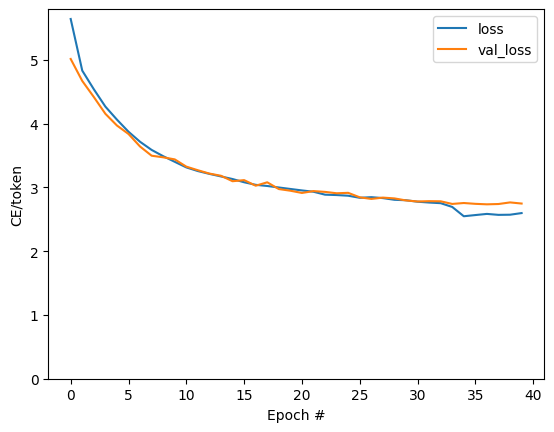

In [ ]:
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.ylim([0, max(plt.ylim())])
plt.xlabel('Epoch #')
plt.ylabel('CE/token')
plt.legend()

## 通过交叉熵计算perplexity

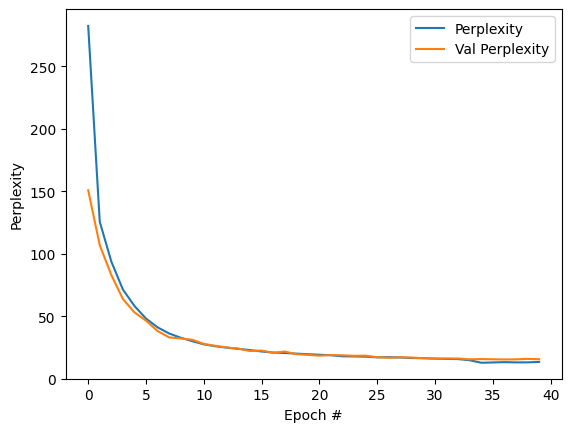

In [ ]:
import numpy as np

plt.plot(np.exp(history.history['loss']), label='Perplexity')
plt.plot(np.exp(history.history['val_loss']), label='Val Perplexity')
plt.ylim([0, max(plt.ylim())])
plt.xlabel('Epoch #')
plt.ylabel('Perplexity')
plt.legend()
plt.show()

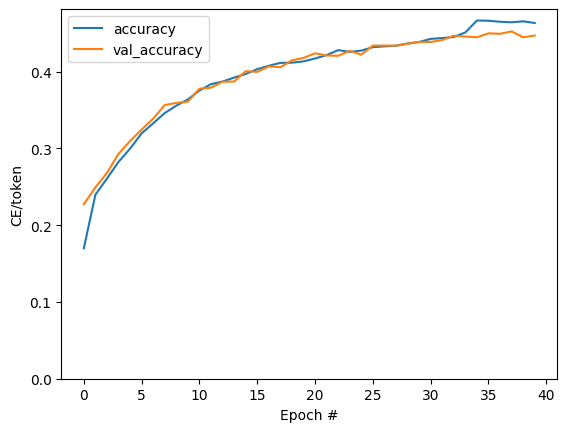

In [ ]:
plt.plot(history.history['masked_acc'], label='accuracy')
plt.plot(history.history['val_masked_acc'], label='val_accuracy')
plt.ylim([0, max(plt.ylim())])
plt.xlabel('Epoch #')
plt.ylabel('CE/token')
plt.legend()

### 翻译

现在模型已经训练完毕，需要实现一个函数来执行完整的翻译。此代码与解码器部分中的推理示例text => text基本相同，但这还捕获了注意力权重。

In [ ]:
@Translator.add_method
def translate(self,
              texts, *,
              max_length=50,
              temperature=0.0):
    # Process the input texts
    context = self.encoder.convert_input(texts)
    batch_size = tf.shape(texts)[0]

    # Setup the loop inputs
    tokens = []
    attention_weights = []
    next_token, done, state = self.decoder.get_initial_state(context)

    for _ in range(max_length):
        # Generate the next token
        next_token, done, state = self.decoder.get_next_token(
            context, next_token, done,  state, temperature)

        # Collect the generated tokens
        tokens.append(next_token)
        attention_weights.append(self.decoder.last_attention_weights)

        if tf.executing_eagerly() and tf.reduce_all(done):
            break

    # Stack the lists of tokens and attention weights.
    tokens = tf.concat(tokens, axis=-1)   # t*[(batch 1)] -> (batch, t)
    self.last_attention_weights = tf.concat(attention_weights, axis=1)  # t*[(batch 1 s)] -> (batch, t s)

    result = self.decoder.tokens_to_text(tokens)
    return result

以下是上面使用的两种辅助方法，用于将标记转换为文本，并获取下一个标记：

In [ ]:
example = ' '.join(jieba.cut('我喜欢你'))
result = model.translate([example])
result[0].numpy().decode()

'i prefer you . '

使用它来生成注意力图：

In [ ]:
@Translator.add_method
def plot_attention(self, text, **kwargs):
    assert isinstance(text, str)
    output = self.translate([text], **kwargs)
    output = output[0].numpy().decode()

    attention = self.last_attention_weights[0]

    context = tf_lower_and_split_punct(text)
    context = context.numpy().decode().split()

    output = tf_lower_and_split_punct(output)
    output = output.numpy().decode().split()[1:]

    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(1, 1, 1)

    ax.matshow(attention, cmap='viridis', vmin=0.0)

    fontdict = {'fontsize': 14}

    ax.set_xticklabels([''] + context, fontdict=fontdict, rotation=90)
    ax.set_yticklabels([''] + output, fontdict=fontdict)

    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

    ax.set_xlabel('Input text')
    ax.set_ylabel('Output text')

<ipython-input-182-3fad64e361b8>:22: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([''] + context, fontdict=fontdict, rotation=90)
<ipython-input-182-3fad64e361b8>:23: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels([''] + output, fontdict=fontdict)
/usr/local/lib/python3.10/dist-packages/IPython/core/events.py:89: UserWarning: Glyph 25105 (\N{CJK UNIFIED IDEOGRAPH-6211}) missing from current font.
  func(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/IPython/core/events.py:89: UserWarning: Glyph 21916 (\N{CJK UNIFIED IDEOGRAPH-559C}) missing from current font.
  func(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/IPython/core/events.py:89: UserWarning: Glyph 27426 (\N{CJK UNIFIED IDEOGRAPH-6B22}) missing from current font.
  func(*args, **kwargs)
/usr/local/lib/pyt

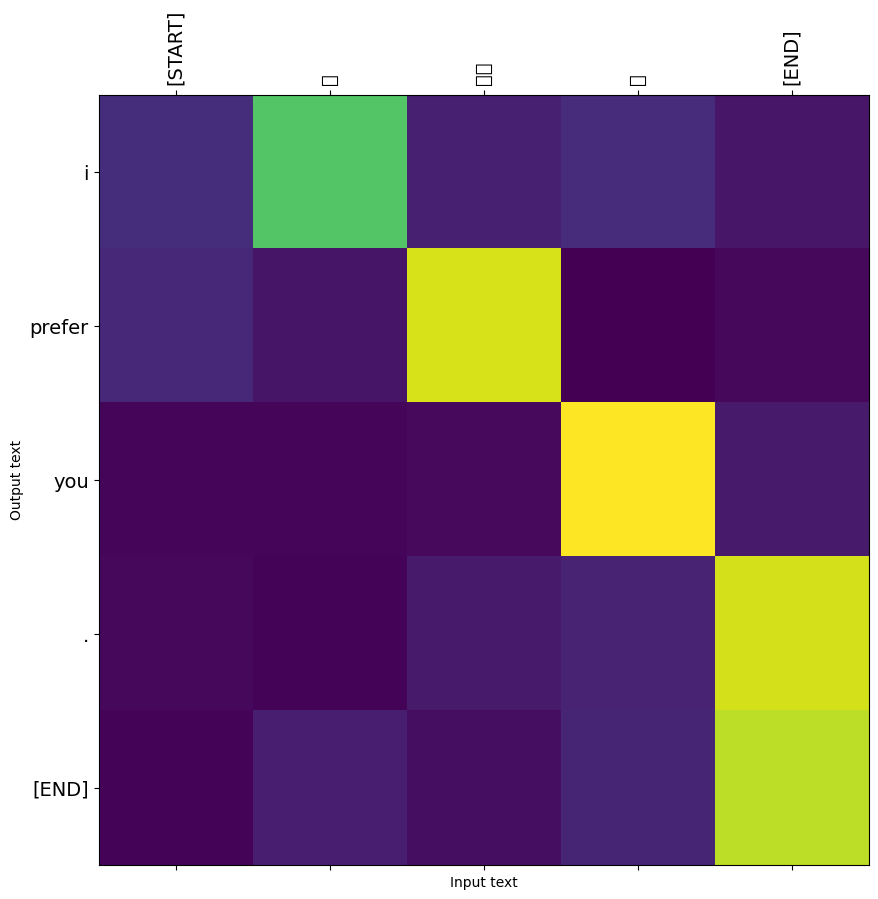

In [ ]:
model.plot_attention(example) # I love you

### 出口

如果要导出此模型，则需要将translate方法包装在 中tf.function。该实现将完成工作：

In [ ]:
class Export(tf.Module):
    def __init__(self, model):
        self.model = model

    @tf.function(input_signature=[tf.TensorSpec(dtype=tf.string, shape=[None])])
    def translate(self, inputs):
        return self.model.translate(inputs)

In [ ]:
export = Export(model)

In [ ]:
tf.saved_model.save(export, 'translator',
                    signatures={'serving_default': export.translate})

## 计算bleu

导入必要的库：

In [ ]:
import nltk
from nltk.translate.bleu_score import sentence_bleu

导入测试数据集：

In [ ]:
zh_test_file = pathlib.Path('data/test.zh')
en_test_file = pathlib.Path('data/test.en')

zh_test_raw = load_zh_data(zh_test_file)
en_test_raw = load_en_data(en_test_file)

print(zh_test_raw[0])
print(en_test_raw[0])

在 美国 ， 艾滋病 活跃分子 走上 街头 ， 甚至 在 1988 年 10 月 的 某日 令 食品 和 药品 监督局 总部 关门   。
In the United States, AIDS activists took to the streets, even shutting down the Food and Drug Administration’s headquarters for a day in October 1988.


翻译测试集：
（由于计算资源有限，仅取前100句进行计算）

In [ ]:
translations = [model.translate([example])[0].numpy().decode() for example in zh_test_raw[:100]]

print(translations[0])

in the united states , aids [UNK] on the street , and even in the streets of october [UNK] , [UNK] [UNK] in october [UNK] . 


In [ ]:
references = [[ref.lower()] for ref in en_val_raw[:100]]

In [ ]:
bleu_scores = []
for i in range(len(translations)):
    # 计算 BLEU-1, BLEU-2, BLEU-3
    score1 = sentence_bleu(references[i], translations[i], weights=(1, 0, 0, 0))
    score2 = sentence_bleu(references[i], translations[i], weights=(0, 1, 0, 0))
    score3 = sentence_bleu(references[i], translations[i], weights=(0, 0, 1, 0))

    # 将 BLEU-1, BLEU-2, BLEU-3 分数存储到列表中
    bleu_scores.append((score1, score2, score3))

# 计算平均 BLEU-1, BLEU-2, BLEU-3 分数
avg_bleu1 = sum([score[0] for score in bleu_scores]) / len(bleu_scores)
avg_bleu2 = sum([score[1] for score in bleu_scores]) / len(bleu_scores)
avg_bleu3 = sum([score[2] for score in bleu_scores]) / len(bleu_scores)

print(f"平均 BLEU-1 分数（前 100 个）: {avg_bleu1}")
print(f"平均 BLEU-2 分数（前 100 个）: {avg_bleu2}")
print(f"平均 BLEU-3 分数（前 100 个）: {avg_bleu3}")

平均 BLEU-1 分数（前 100 个）: 0.3665379014589563
平均 BLEU-2 分数（前 100 个）: 0.17009023226785036
平均 BLEU-3 分数（前 100 个）: 0.0582781761072587


## 英文翻译中文

只需要将target和context对调即可。

In [ ]:
target_raw = np.concatenate((zh_train_raw, zh_val_raw))
train_raw = np.concatenate((en_train_raw, en_val_raw))

后续操作与训练中译英模型完全一致，经验证后，可以得到与中译英模型相似的训练效果

## 实验总结

	1.	数据处理：
		数据清洗与预处理（如分词、加入特殊标记等）。
		将中英文语料转化为序列张量，并进行 Padding。
	2.	模型设计：
		编码器（GRU + 嵌入层）。
		注意力机制（CrossAttention）。
		解码器（GRU + 嵌入层 + 全连接层）。
	3.	训练与优化：
	    使用交叉熵损失（SparseCategoricalCrossentropy）。
		教师强制（Teacher Forcing）机制。
		优化器（Adam）。
	4.	保存与恢复模型：
		使用 TensorFlow 的检查点机制保存和加载模型。
	5.	评估：
		编写了 BLEU 和 Perplexity 的计算方法。
	6.	翻译测试：
		通过 translate 函数完成中译英句子生成。